In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset & Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [7]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

## Arsitektur & Config

In [9]:
from jcopdl.layers import conv_block, linear_block

In [ ]:
# nn.Conv2d(3, 8, 3, 1, 1)
# nn.ReLU()
# nn.MaxPool2d(2, 2)

In [10]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [13]:
config = {
    "bs" : bs,
    "crop_size" : crop_size
}

## Training Preparation

In [16]:
model = CustomCNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

## Training

In [17]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6951 | Test_cost  = 0.6902 | Train_score = 0.4920 | Test_score = 0.5000 |




Epoch     2
Train_cost  = 0.6847 | Test_cost  = 0.6703 | Train_score = 0.5670 | Test_score = 0.6425 |




Epoch     3
Train_cost  = 0.6466 | Test_cost  = 0.6004 | Train_score = 0.6860 | Test_score = 0.7375 |




Epoch     4
Train_cost  = 0.5530 | Test_cost  = 0.5552 | Train_score = 0.7400 | Test_score = 0.7150 |
==> EarlyStop patience =  1 | Best test_score: 0.7375




Epoch     5
Train_cost  = 0.5042 | Test_cost  = 0.5608 | Train_score = 0.7540 | Test_score = 0.7000 |
==> EarlyStop patience =  2 | Best test_score: 0.7375




Epoch     6
Train_cost  = 0.5293 | Test_cost  = 0.4551 | Train_score = 0.7460 | Test_score = 0.7875 |




Epoch     7
Train_cost  = 0.4663 | Test_cost  = 0.4323 | Train_score = 0.7910 | Test_score = 0.8125 |




Epoch     8
Train_cost  = 0.4295 | Test_cost  = 0.4175 | Train_score = 0.8020 | Test_score = 0.8150 |




Epoch     9
Train_cost  = 0.4167 | Test_cost  = 0.3834 | Train_score = 0.8090 | Test_score = 0.8325 |




Epoch    10
Train_cost  = 0.3865 | Test_cost  = 0.3868 | Train_score = 0.8250 | Test_score = 0.8300 |
==> EarlyStop patience =  1 | Best test_score: 0.8325




Epoch    11
Train_cost  = 0.3866 | Test_cost  = 0.3535 | Train_score = 0.8300 | Test_score = 0.8425 |




Epoch    12
Train_cost  = 0.3632 | Test_cost  = 0.3611 | Train_score = 0.8370 | Test_score = 0.8250 |
==> EarlyStop patience =  1 | Best test_score: 0.8425




Epoch    13
Train_cost  = 0.3554 | Test_cost  = 0.3878 | Train_score = 0.8450 | Test_score = 0.8150 |
==> EarlyStop patience =  2 | Best test_score: 0.8425




Epoch    14
Train_cost  = 0.3525 | Test_cost  = 0.3327 | Train_score = 0.8390 | Test_score = 0.8525 |




Epoch    15
Train_cost  = 0.3437 | Test_cost  = 0.3231 | Train_score = 0.8520 | Test_score = 0.8775 |




Epoch    16
Train_cost  = 0.3658 | Test_cost  = 0.3645 | Train_score = 0.8400 | Test_score = 0.8250 |
==> EarlyStop patience =  1 | Best test_score: 0.8775




Epoch    17
Train_cost  = 0.3659 | Test_cost  = 0.3202 | Train_score = 0.8450 | Test_score = 0.8700 |
==> EarlyStop patience =  2 | Best test_score: 0.8775




Epoch    18
Train_cost  = 0.3436 | Test_cost  = 0.3233 | Train_score = 0.8460 | Test_score = 0.8700 |
==> EarlyStop patience =  3 | Best test_score: 0.8775




Epoch    19
Train_cost  = 0.3168 | Test_cost  = 0.3092 | Train_score = 0.8660 | Test_score = 0.8675 |
==> EarlyStop patience =  4 | Best test_score: 0.8775




Epoch    20
Train_cost  = 0.3204 | Test_cost  = 0.2933 | Train_score = 0.8550 | Test_score = 0.8875 |


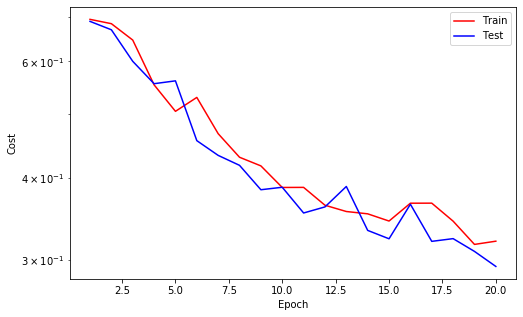

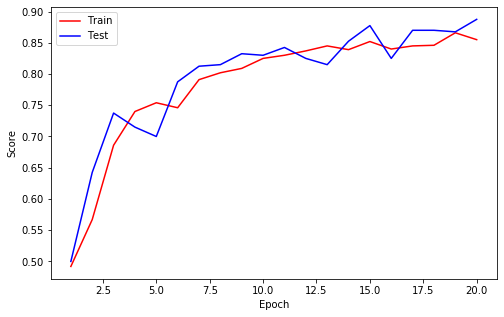



Epoch    21
Train_cost  = 0.3166 | Test_cost  = 0.2943 | Train_score = 0.8720 | Test_score = 0.8800 |
==> EarlyStop patience =  1 | Best test_score: 0.8875




Epoch    22
Train_cost  = 0.3328 | Test_cost  = 0.3385 | Train_score = 0.8510 | Test_score = 0.8575 |
==> EarlyStop patience =  2 | Best test_score: 0.8875




Epoch    23
Train_cost  = 0.3337 | Test_cost  = 0.3446 | Train_score = 0.8550 | Test_score = 0.8550 |
==> EarlyStop patience =  3 | Best test_score: 0.8875




Epoch    24
Train_cost  = 0.3072 | Test_cost  = 0.2895 | Train_score = 0.8720 | Test_score = 0.8900 |




Epoch    25
Train_cost  = 0.3033 | Test_cost  = 0.2866 | Train_score = 0.8650 | Test_score = 0.8800 |
==> EarlyStop patience =  1 | Best test_score: 0.8900




Epoch    26
Train_cost  = 0.2865 | Test_cost  = 0.2942 | Train_score = 0.8800 | Test_score = 0.8825 |
==> EarlyStop patience =  2 | Best test_score: 0.8900




Epoch    27
Train_cost  = 0.2838 | Test_cost  = 0.2839 | Train_score = 0.8740 | Test_score = 0.8825 |
==> EarlyStop patience =  3 | Best test_score: 0.8900




Epoch    28
Train_cost  = 0.2796 | Test_cost  = 0.2704 | Train_score = 0.8840 | Test_score = 0.8875 |
==> EarlyStop patience =  4 | Best test_score: 0.8900




Epoch    29
Train_cost  = 0.2562 | Test_cost  = 0.2703 | Train_score = 0.8850 | Test_score = 0.8800 |
==> EarlyStop patience =  5 | Best test_score: 0.8900
==> Execute Early Stopping at epoch: 29 | Best test_score: 0.8900
==> Best model is saved at model


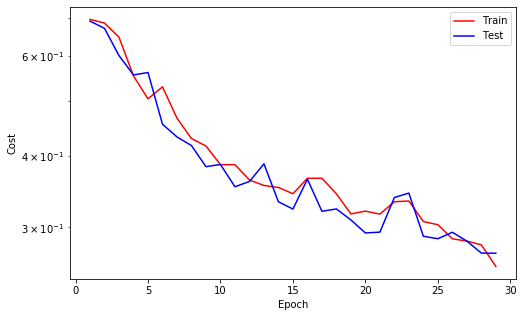

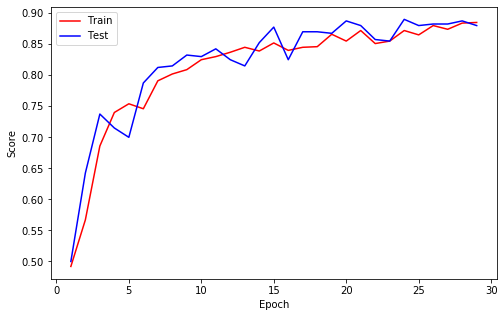

In [18]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Predict

In [19]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [21]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds    

tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 1])

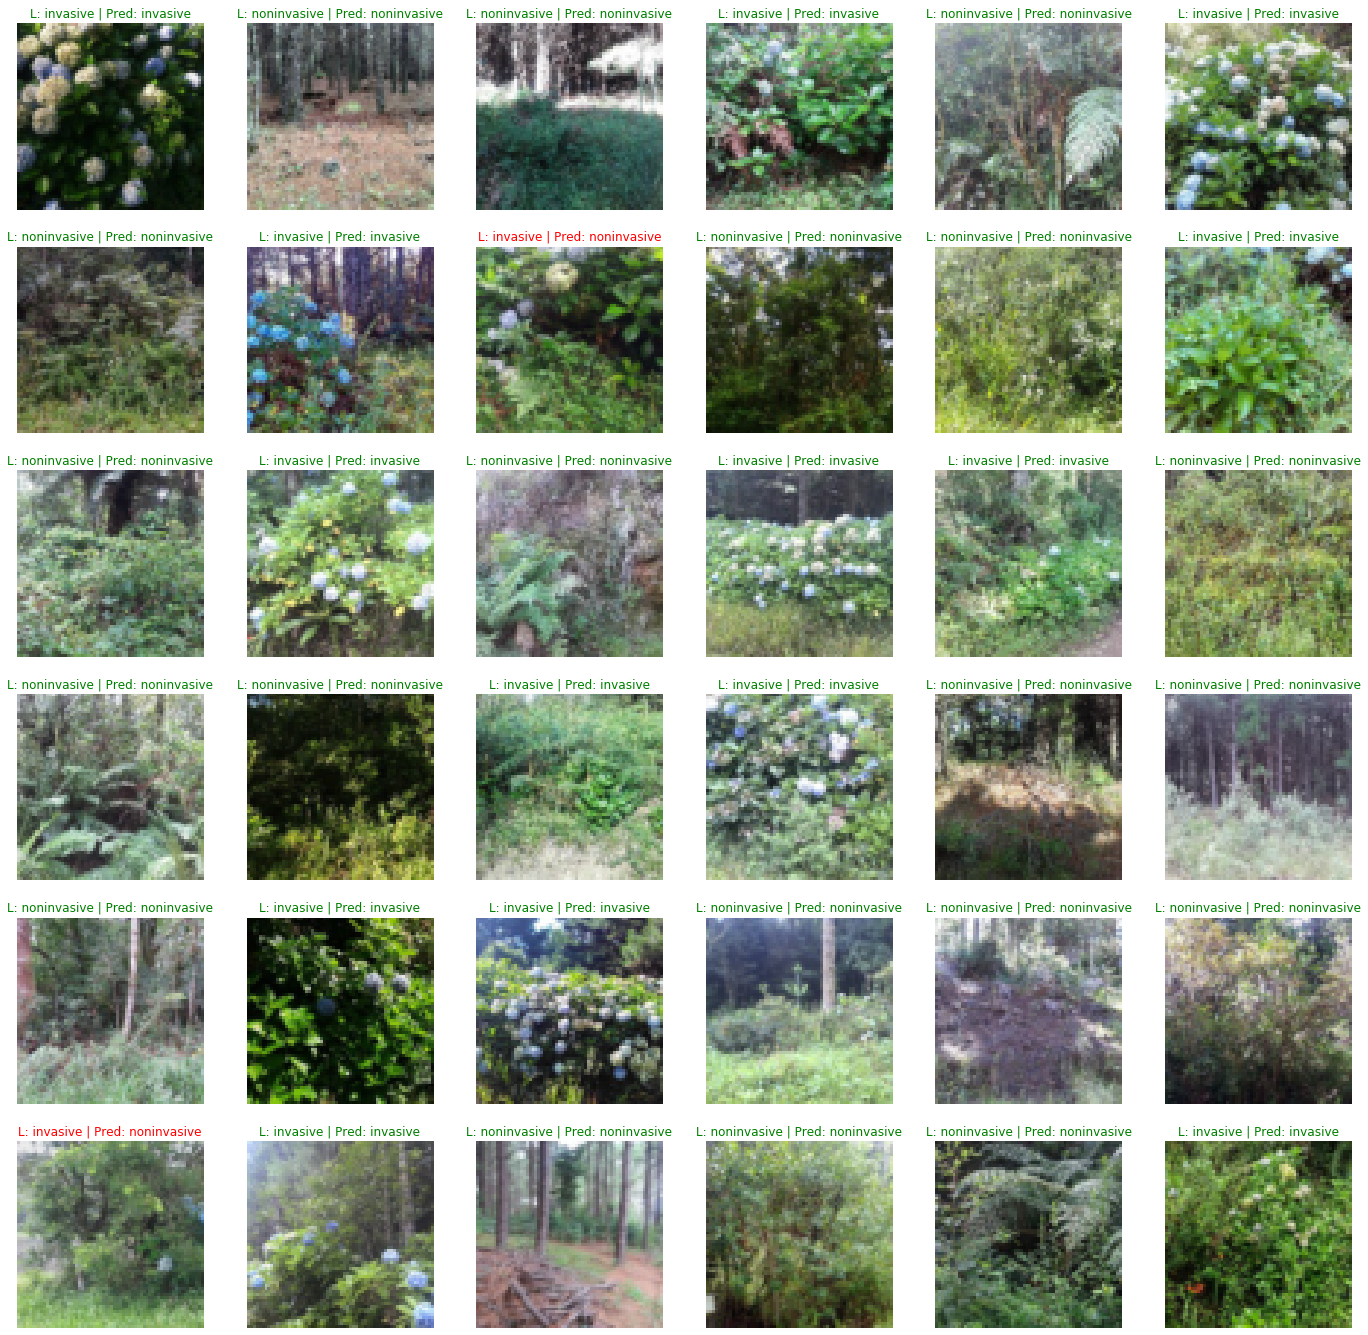

In [24]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))

for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color" : 'r'} if label != pred else {"color" : 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | Pred: {pred}", fontdict=font);
    ax.axis("off");
